In [ ]:
import docker
docker_client = docker.from_env()
img = docker_client.images.pull(
            "ghcr.io/becksteinlab/streaming-md-docker:main-Common-CPU"
        )

container = docker_client.containers.run(
            img,
            f"/bin/sh -c 'cd /tmp && ./run.sh'",
            detach=True,
            volumes={"/nfs/homes3/ljwoods2/workspace/imd-workshop-2024/gromacs-demos/distances": {"bind": "/tmp", "mode": "rw"}},
            ports={"8888/tcp": 8888},
            name="sim",
            remove=True,
        )

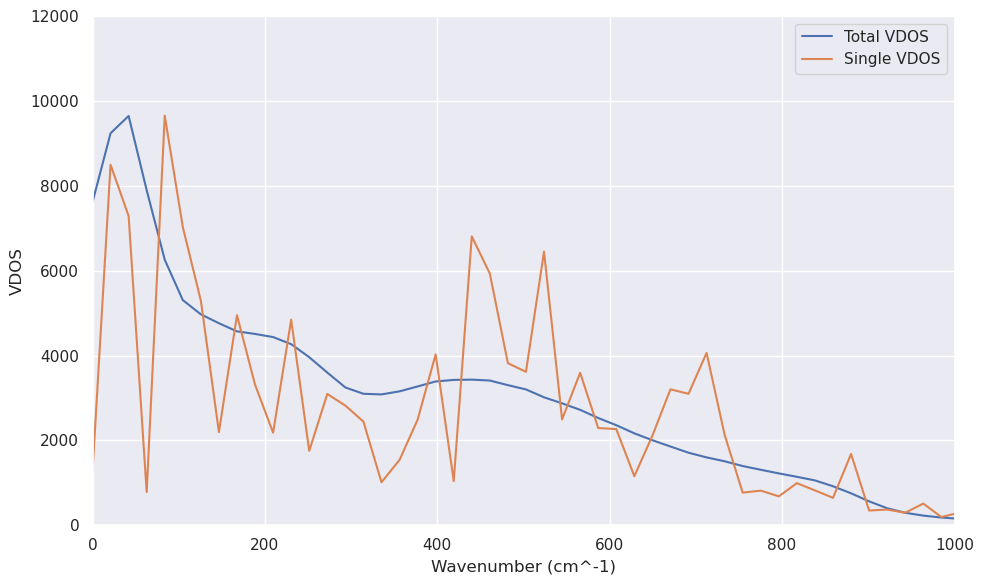

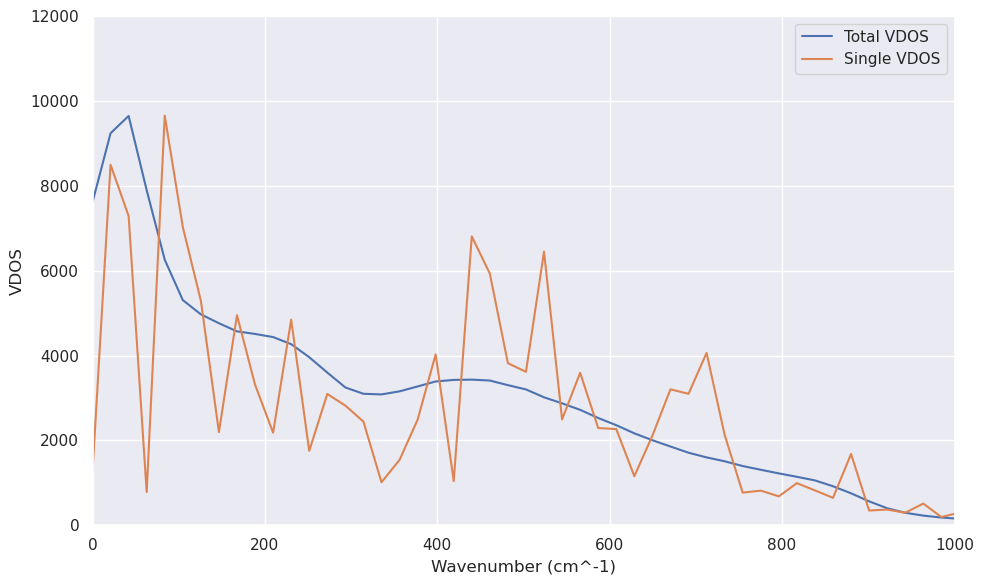

In [2]:
from imdclient.IMDREADER import IMDReader
import numpy as np
import MDAnalysis as mda
import logging
import ctypes as ct
from scipy.fft import fft
import dynplot as dyn
import vdos as vd
import time as t
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

# %%
logger = logging.getLogger("imdclient.IMDClient")
file_handler = logging.FileHandler("imdreader.log")
formatter = logging.Formatter(
    "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)
logger.setLevel(logging.INFO)

# %%
u = mda.Universe("mda.tpr", "imd://localhost:8888",buffersize = 10*1024*1024)
sel = u.select_atoms("resname SOL")
vdos = vd.vdos(sel,200)

vd.vdosLib.omp_set_num_threads(2)

plt.ion()  # Turn on interactive mode
fig, ax = plt.subplots(figsize=(10, 6))
p_total, = ax.plot([], [], label='Total VDOS')
p_single, = ax.plot([], [], label='Single VDOS')
ax.set_xlabel('Wavenumber (cm^-1)')
ax.set_ylabel('VDOS')
ax.set_xlim(0, 1000)
ax.set_ylim(0, 12000)
#ax.set_title('VDOS')
ax.legend()
ax.grid(True)
plt.tight_layout()
display(fig)

tStep = 0

for ts in u.trajectory:
    vdos.single_frame(tStep,ts.time)
    if tStep == 0:
        pass

    if tStep % 200 == 0:
        vdos.copyResidueList()
        vdos.postProcess(vdos.residueListCopy,mode = "total+single")
        total = np.array(vdos.totVDoS[0])
        single = np.array(vdos.totVDoS[1])
        p_total.set_data(vdos.wavenumber, total)
        p_single.set_data(vdos.wavenumber, single)
        
        clear_output(wait=True)  # Clear previous output
        display(fig)  # Redisplay the updated figure
    
    tStep += 1
    
# %%
logger.info(f"Parsed {tStep} frames")
plt.ioff()